In [61]:
import numpy as np

import tensorflow as tf
from tensorflow_probability import distributions as tfd

import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from src.utils.data_loader import load_data

In [44]:
data_dir = "/Users/leah/Columbia/courses/19summer/microbialdynamics/data/microbio.p"

In [46]:
with open(data_dir, "rb") as handle:
    data = pickle.load(handle)

In [58]:
Dx = 3

In [82]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test = load_data(data_dir, Dx, False, False)

In [62]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


def interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, dirichlet_emission):
    interpolated_hidden_train = []
    interpolated_hidden_test = []
    interpolated_obs_train = []
    interpolated_obs_test = []
    interpolated_input_train = []
    interpolated_input_test = []
    mask_train = []
    mask_test = []
    time_interval_train = []
    time_interval_test = []

    for hidden, obs, input in zip(hidden_train, obs_train, input_train):
        hidden, obs, input, mask, time_interval = interpolate_datapoint(hidden, obs, input, dirichlet_emission)
        interpolated_hidden_train.append(hidden)
        interpolated_obs_train.append(obs)
        interpolated_input_train.append(input)
        mask_train.append(mask)
        time_interval_train.append(time_interval)

    for hidden, obs, input in zip(hidden_test, obs_test, input_test):
        hidden, obs, input, mask, time_interval = interpolate_datapoint(hidden, obs, input, dirichlet_emission)
        interpolated_hidden_test.append(hidden)
        interpolated_obs_test.append(obs)
        interpolated_input_test.append(input)
        mask_test.append(mask)
        time_interval_test.append(time_interval)

    return interpolated_hidden_train, interpolated_hidden_test, \
           interpolated_obs_train, interpolated_obs_test, \
           interpolated_input_train, interpolated_input_test, \
           mask_train, mask_test, time_interval_train, time_interval_test


def interpolate_datapoint(hidden, obs, input, dirichlet_emission):
    """

    :param hidden: (n_obs, Dx)
    :param obs: (n_obs, Dy + 1), [:, 0] records t of all obs
    :param input: (n_inputs, Dy + 1], [:, 0] records t of all inputs
    :return:
    hidden: (time, Dx)
    obs: (time, Dy)
    interpolated_input: (time, Dv)
    mask: (time, )
    time_interval: (time, )
    """
    days = obs[:, 0].astype(int)
    time = days[-1] - days[0] + 1

    mask = np.ones((time, ), dtype=bool)
    time_interval = np.zeros((time, ))

    i = 0
    for t in np.arange(days[0], days[-1] + 1):
        idx = t - days[0]
        if t == days[i]:
            i = i + 1
            time_interval[idx] = 0
        else:
            mask[t - days[0]] = False
            time_interval[idx] = time_interval[idx - 1] + 1

    # hidden
    hidden = np.zeros((time, hidden.shape[1]))

    # obs
    Dy = obs.shape[1] - 1
    i = 0
    if dirichlet_emission:
        interpoated_obs = np.zeros((time, Dy))
        last_valid_value = np.ones(Dy) / Dy
        for t in np.arange(days[0], days[-1] + 1):
            if t == days[i]:
                smoothed_obs = obs[i, 1:]
                smoothed_obs = smoothed_obs * (1 - 1e-6) + 1e-6 / Dy
                interpoated_obs[t - days[0]] = smoothed_obs
                last_valid_value = smoothed_obs
                i += 1
            else:
                interpoated_obs[t - days[0]] = last_valid_value
    else:
        X = np.atleast_2d(days).T
        y = obs[:, 1:]

        kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        noise = 1e-2
        gp = GaussianProcessRegressor(kernel=kernel, alpha=noise ** 2, n_restarts_optimizer=10)
        gp.fit(X, y)

        X_pred = np.atleast_2d(np.arange(days[0], days[-1] + 1)).T
        interpoated_obs, sigma = gp.predict(X_pred, return_std=True)

        # plt.figure()
        # plt.plot(X_pred, interpoated_obs, 'b-', label='Prediction')
        # plt.fill(np.concatenate([X_pred, X_pred[::-1]]),
        #          np.concatenate([interpoated_obs - 1.9600 * sigma,
        #                          (interpoated_obs + 1.9600 * sigma)[::-1]]),
        #          alpha=.5, fc='b', ec='None', label='95% confidence interval')
        # plt.xlabel('$x$')
        # plt.ylabel('$y$')
        # plt.legend(loc='upper left')
        # plt.show()

    # input
    Dv = input.shape[1] - 1
    interpoated_input = np.zeros((time, Dv))
    for day_input in input:
        day = int(day_input[0])
        if days[0] <= day <= days[-1]:
            interpoated_input[day - days[0]] = day_input[1:]

    return hidden, interpoated_obs, interpoated_input, mask, time_interval







In [83]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, \
        _mask_train, _mask_test, time_interval_train, time_interval_test = \
            interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, dirichlet_emission=False)

In [84]:
len(obs_train)

17

In [85]:
obs_train[0].shape

(42, 11)

In [87]:
obs_train[0].shape

(42, 11)

In [89]:
data['Ytrain'][0].shape

(20, 12)

In [97]:
data['Ytrain'][0][:,1:].sum(axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [4]:
T = 2
Dy = 3

lambdas = tf.placeholder(tf.float32, shape=(T, Dy))

In [5]:
poisson = tfd.Poisson(rate=lambdas,
                                  validate_args=True,
                                  allow_nan_stats=False)

In [6]:
lambdas_value = np.array([[1,1,1],[2,2,2]])

In [27]:
batch_size = 1
samples = poisson.sample(1)

In [28]:
with tf.Session() as sess:
    samples_val = sess.run(samples, feed_dict={lambdas: lambdas_value})

In [29]:
samples_val.shape

(1, 2, 3)

In [30]:
samples_val

array([[[1., 1., 0.],
        [4., 0., 2.]]], dtype=float32)

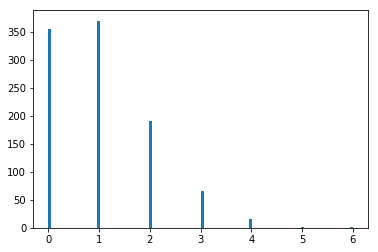

In [15]:
plt.hist(samples_val[:,0,0], bins=100);

In [37]:
obs = tf.placeholder(tf.float32, shape=(T, Dy))

log_probs = poisson.log_prob(obs)

In [39]:
with tf.Session() as sess:
    log_probs_val = sess.run(log_probs, feed_dict={lambdas: lambdas_value, obs: samples_val[0]})

In [40]:
log_probs_val.shape

(2, 3)

In [41]:
log_probs_val

array([[-1.       , -1.       , -1.       ],
       [-2.4054651, -2.       , -1.3068528]], dtype=float32)

In [99]:
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [101]:
np.zeros((2,))

array([0., 0.])

In [102]:
samples

<tf.Tensor 'Poisson_1/sample_5/Reshape:0' shape=(1, 2, 3) dtype=float32>

In [103]:
samples_val

array([[[1., 1., 0.],
        [4., 0., 2.]]], dtype=float32)

AttributeError: module 'tensorflow' has no attribute 'sum'